In [1]:
import os
from typing import List

import skfda
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
import numpy as np

# Funkcje pomocnicze
def create_wav_matrix_raw(directory: str) -> List[List[int]]:
    if not os.path.isdir(directory):
        raise NotADirectoryError('Directory not found')

    data_matrix = []
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            _, data = wavfile.read(os.path.join(directory, filename))
            data_matrix.append(data)
    return data_matrix


def create_wav_fdatagrid(directory: str):
    if not os.path.isdir(directory):
        raise NotADirectoryError('Directory not found')

    samplerate = None
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            samplerate, _ = wavfile.read(os.path.join(directory, filename))
            break

    if samplerate:
        grid_points = [x for x in range(0, samplerate)]
        data_matrix = create_wav_matrix_raw(directory)
    else:
        raise FileNotFoundError('There are no WAV files inside given directory.')

    return skfda.FDataGrid(
        data_matrix=data_matrix,
        grid_points=grid_points,
    )


def transform_time_to_fft(fDataGrid, normalize=True):
    fft_data_matrix = []
    samplerate = len(fDataGrid.grid_points[0])
    
    for row in fDataGrid.data_matrix:
        data = 2.0/samplerate * np.abs(fft(row)[0:samplerate//2])
        if normalize:
            data = (data - np.min(data)) / (np.max(data) - np.min(data))
        fft_data_matrix.append(data)
    
    xf = fftfreq(samplerate, 1/samplerate)[:samplerate//2]
    return skfda.FDataGrid(
        data_matrix=fft_data_matrix,
        grid_points=xf,
    )

In [2]:
dir_10 = '../data/wiertarka/CM_10_zabkow_wiatrak/'
dir_5 = '../data/wiertarka/CM_5_zabkow_wiatrak/'
dir_2 = '../data/wiertarka/CM_2zeby_wentylator/'
dir_1 = '../data/wiertarka/CM_1zab.czarny/'
dir_up = '../data/wiertarka/CM_uszk_przekladnia/'

# Wczytanie danych z katalogow
fd_10 = create_wav_fdatagrid(dir_10)
fd_5 = create_wav_fdatagrid(dir_5)
fd_2 = create_wav_fdatagrid(dir_2)
fd_1 = create_wav_fdatagrid(dir_1)
fd_up = create_wav_fdatagrid(dir_up)

#Transformacja fft
fd_10_fft = transform_time_to_fft(fd_10, normalize=True)
fd_5_fft = transform_time_to_fft(fd_5, normalize=True)
fd_2_fft = transform_time_to_fft(fd_2, normalize=True)
fd_1_fft = transform_time_to_fft(fd_1, normalize=True)
fd_up_fft = transform_time_to_fft(fd_up, normalize=True)


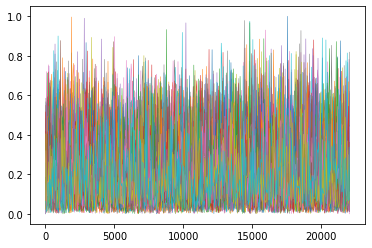

In [3]:
import matplotlib.pyplot as plt

# Wybor 2 klas
fd1 = fd_2_fft
fd2 = fd_5_fft

fd1_label = '2 zeby'
fd2_label = '5 zebo'

fd_fft = fd1.concatenate(fd2)
fd_fft.plot(linewidth=0.5)
plt.show()

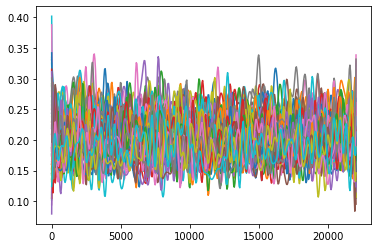

In [4]:
from skfda.representation.basis import BSpline

bss = BSpline(n_basis=100)
fd_fft_basis = fd_fft.to_basis(bss)
fd_fft_basis = fd_fft_basis.to_grid()
fd_fft_basis.plot()
plt.show()

In [5]:
print(fd_fft_basis.n_samples)

60


[0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0]
Model accuracy:  0.7666666666666667


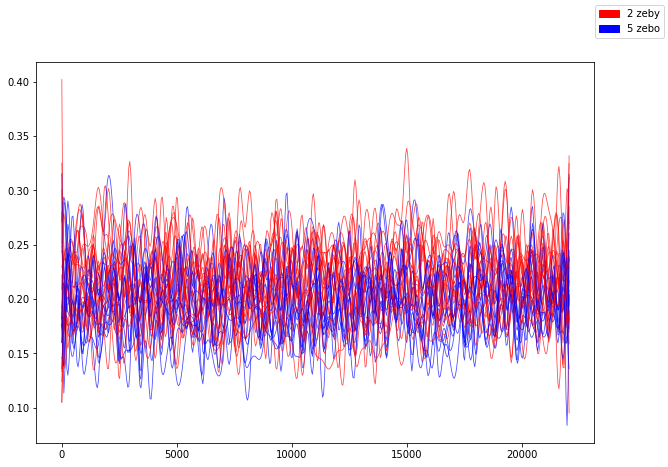

In [6]:
from skfda.ml.classification import LogisticRegression

fd_size = fd_fft_basis.n_samples
y = fd_size//2*[0] + fd_size//2*[1];

x_train = fd_fft_basis[::2]
x_val = fd_fft_basis[1::2]
y_train = y[::2]
y_val = y[1::2]

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_val)
print(y_pred)
print("Model accuracy: ", model.score(x_val, y_val))

labels_pred = np.full(len(y_pred), fd1_label)
labels_pred[y_pred==1] = fd2_label
colors = {
    fd1_label: 'red',
    fd2_label: 'blue',
}
fig = plt.figure(figsize=(10, 7))
x_val.plot(
    fig=fig,
    group=labels_pred,
    group_colors=colors,
    linewidth=0.8,
    alpha=0.7,
    legend=True,
)
plt.show()